#  Identify the driver regulators of cell fate decisions
CEFCON is a computational tool for deciphering driver regulators of cell fate decisions from single-cell RNA-seq data. It takes a prior gene interaction network and expression profiles from scRNA-seq data associated with a given developmental trajectory as inputs, and consists of three main components, including cell-lineage-specific gene regulatory network (GRN) construction, driver regulator identification and regulon-like gene module (RGM) identification.

Check out [(Wang et al., Nature Communications, 2023)](https://www.nature.com/articles/s41467-023-44103-3) for the detailed methods and applications.

Code: [https://github.com/WPZgithub/CEFCON](https://github.com/WPZgithub/CEFCON)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
#print(f"omicverse version: {ov.__version__}")
import scanpy as sc
#print(f"scanpy version: {sc.__version__}")
import pandas as pd
from tqdm.auto import tqdm
ov.plot_set(font_path='Arial')
!date

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 15:47:06 CST


# Data loading and processing
Here, we use the mouse hematopoiesis data provided by [Nestorowa et al. (2016, Blood).](https://doi.org/10.1182/blood-2016-05-716480)

**The scRNA-seq data requires processing to extract lineage information for the CEFCON analysis.** Please refer to the [original notebook](https://github.com/WPZgithub/CEFCON/blob/e74d2d248b88fb3349023d1a97d3cc8a52cc4060/notebooks/preprocessing_nestorowa16_data.ipynb) for detailed instructions on preprocessing scRNA-seq data.

In [3]:
adata = ov.single.mouse_hsc_nestorowa16()
adata

Load mouse_hsc_nestorowa16_v0.h5ad


AnnData object with n_obs × n_vars = 1645 × 3000
    obs: 'E_pseudotime', 'GM_pseudotime', 'L_pseudotime', 'label_info', 'n_genes', 'leiden', 'cell_type_roughly', 'cell_type_finely'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'E_pseudotime_logFC', 'GM_pseudotime_logFC', 'L_pseudotime_logFC'
    uns: 'cell_type_finely_colors', 'cell_type_roughly_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'lineages', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'connectivities', 'distances'

CEFCON fully exploit an available global and **context-free gene interaction network** as prior knowledge, from which we extract the cell-lineage-specific gene interactions according to the gene expression profiles derived from scRNA-seq data associated with a given developmental trajectory. 

You can download the prior network in the [zenodo](https://zenodo.org/records/8013900). **CEFCON only provides the prior network for human and mosue data anaylsis**. For other species, you should provide the prior network mannully.

The author of CEFCON has provided several prior networks here; however, 'nichenet' yields the best results.

In [4]:
prior_network = ov.single.load_human_prior_interaction_network(dataset='nichenet') 

Load the prior gene interaction network: nichenet. #Genes: 25345, #Edges: 5290993


**In the scRNA-seq analysis of human data, you should not run this step. Running it may change the gene symbol and result in errors.**





In [5]:
# Convert the gene symbols of the prior gene interaction network to the mouse gene symbols
prior_network = ov.single.convert_human_to_mouse_network(prior_network,server_name='asia')
prior_network

Convert genes of the prior interaction network to mouse gene symbols:


Processing:   0%|          | 0/10 [00:00<?, ?it/s]

Server 'http://asia.ensembl.org/biomart/' is OK


Converting ambiguous gene symbols:   0%|          | 0/188141 [00:00<?, ?it/s]

The converted prior gene interaction network: #Genes: 18569, #Edges: 4991344


,from,to
0,Klf2,Dlgap1
2,Klf2,Bhlhe40
3,Klf2,Rps6ka1
4,Klf2,Pxn
5,Klf2,Ube2v1
...,...,...
837042,Zranb1,B020011L13Rik
837043,Zranb1,Zfy2
837044,Zranb1,Zfy1
837047,Zscan21,Zfy2


In [6]:
prior_network.to_csv('result/combined_network_Mouse.txt.gz',sep='\t')

Alternatively, you can directly specify the file path of the input prior interaction network and import the specified file.

In [7]:
#prior_network = './Reference_Networks/combined_network_Mouse.txt'
prior_network=ov.read('result/combined_network_Mouse.txt.gz',index_col=0)

# Training CEFCON model

We recommend using GRUOBI to solve the integer linear programming (ILP) problem when identifying driver genes. GUROBI is a commercial solver that requires licenses to run. Thankfully, it provides free licenses in academia, as well as trial licenses outside academia. If there is no problem about the licenses, you need to install the `gurobipy` package.

If difficulties arise while using GUROBI, the non-commercial solver, SCIP, will be employed as an alternative. But the use of SCIP does not come with a guarantee of achieving a successful solutio

**By default, the program will verify the availability of GRUOBI. If GRUOBI is not accessible, it will automatically switch the solver to SCIP.**


In [8]:
CEFCON_obj = ov.single.pyCEFCON(adata, prior_network, repeats=5, solver='GUROBI')
CEFCON_obj

Construct cell-lineage-specific GRNs

In [9]:
CEFCON_obj.preprocess()

Start data preparation

[0] - Data loading and preprocessing...
Consider the input data with 3 lineages:
  Lineage - E_pseudotime:
    2864 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 89831.
    n_genes × n_cells = 2778 × 1065
  Lineage - GM_pseudotime:
    100 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 89931.
    n_genes × n_cells = 2778 × 882
  Lineage - L_pseudotime:
    4 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 89935.
    n_genes × n_cells = 2778 × 843


Lineage-by-lineage computation:

In [10]:
CEFCON_obj.train()

Start model training

[1] - Constructing cell-lineage-specific GRN...
  Lineage - E_pseudotime: 


  Iter: 5/5: 100%|███████████████| 350/350 [00:40<00:00,  8.65it/s, loss=0.000291, min_loss=0.00015]


[1] - Constructing cell-lineage-specific GRN...
  Lineage - GM_pseudotime: 


  Iter: 5/5: 100%|██████████████| 350/350 [00:40<00:00,  8.72it/s, loss=0.000391, min_loss=0.000184]


[1] - Constructing cell-lineage-specific GRN...
  Lineage - L_pseudotime: 


  Iter: 5/5: 100%|██████████████| 350/350 [00:40<00:00,  8.73it/s, loss=0.000225, min_loss=0.000163]


Finish model training



In [11]:
# Idenytify driver regulators for each lineage
CEFCON_obj.predicted_driver_regulators()

Start predict lineage - E_pseudotime:
Start calculate gene influence score - E_pseudotime:
Start calculate gene driver regulators - E_pseudotime:
[2] - Identifying driver regulators...
Restricted license - for non-production use only - expires 2026-11-23
  Solving MFVS problem...
    179 critical nodes are found.
    0 nodes left after graph reduction operation.
  179 MFVS driver genes are found.
  Solving MDS problem...
    14 critical nodes are found.
    1180 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
      Solving by GUROBI...(optimal value with GUROBI:122.0,  status:optimal)
  136 MDS driver genes are found.
Start predict lineage - GM_pseudotime:
Start calculate gene influence score - GM_pseudotime:
Start calculate gene driver regulators - GM_pseudotime:
[2] - Identifying driver regulators...
  Solving MFVS problem...
    203 critical nodes are found.
    0 nodes left after graph reduction operation.
  203

We can find out the driver regulators identified by CEFCON.

In [12]:
CEFCON_obj.cefcon_results_dict['E_pseudotime'].driver_regulator.head()

,influence_score,is_driver_regulator,is_MFVS_driver,is_MDS_driver,is_TF
JUN,7.348739,True,True,True,True
GATA1,7.119549,True,True,True,True
FOS,6.901873,True,True,True,True
GATA2,6.699804,True,True,True,True
MEIS1,5.822881,True,True,True,True


In [13]:
CEFCON_obj.predicted_RGM()

Start calculate regulon-like gene modules - E_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
Start calculate regulon-like gene modules - GM_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
Start calculate regulon-like gene modules - L_pseudotime:
[3] - Identifying regulon-like gene modules...
Done!
Finish predicted



# Downstream analysis

In [14]:
CEFCON_obj.cefcon_results_dict['E_pseudotime']

CefconResults object with n_cells * n_genes = 1065 * 2727, n_edges = 22224
    name: E_pseudotime
    expression_data: yes
    network: DiGraph with 2727 nodes and 22197 edges
    gene_embedding: # dimension = 64
    influence_score: yes
    driver_regulator: yes
    gene_cluster: None
    RGMs_AUCell_dict: yes

In [15]:
lineage = 'E_pseudotime'
result = CEFCON_obj.cefcon_results_dict[lineage]

Plot gene embedding clusters

In [16]:
gene_ad=sc.AnnData(result.gene_embedding)
sc.pp.neighbors(gene_ad, n_neighbors=30, use_rep='X')
# Higher resolutions lead to more communities, while lower resolutions lead to fewer communities.
sc.tl.leiden(gene_ad, resolution=1)
sc.tl.umap(gene_ad, n_components=2, min_dist=0.3)

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


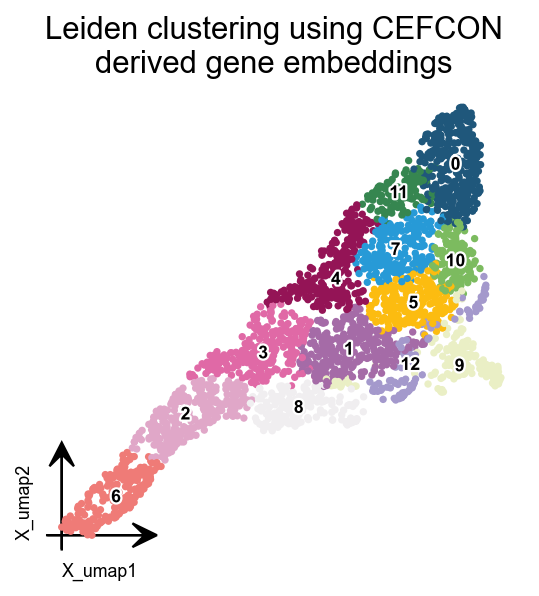

In [17]:
ov.utils.embedding(gene_ad,basis='X_umap',legend_loc='on data',
                       legend_fontsize=8, legend_fontoutline=2,
                  color='leiden',frameon='small',title='Leiden clustering using CEFCON\nderived gene embeddings')

Plot influence scores of driver regulators

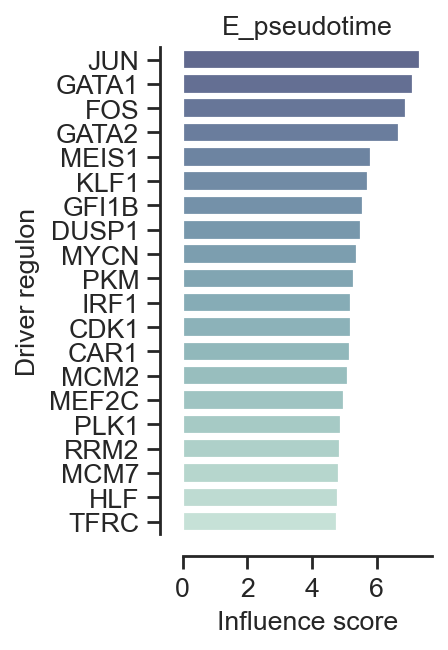

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
data_for_plot = result.driver_regulator[result.driver_regulator['is_driver_regulator']]
data_for_plot = data_for_plot[0:20]

plt.figure(figsize=(2, 20 * 0.2))
sns.set_theme(style='ticks', font_scale=0.5)

ax = sns.barplot(x='influence_score', y=data_for_plot.index, data=data_for_plot, orient='h',
                 palette=sns.color_palette(f"ch:start=.5,rot=-.5,reverse=1,dark=0.4", n_colors=20))
ax.set_title(result.name)
ax.set_xlabel('Influence score')
ax.set_ylabel('Driver regulators')

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('E_pseudotime',fontsize=12)
plt.xlabel('Influence score',fontsize=12)
plt.ylabel('Driver regulon',fontsize=12)

sns.despine()

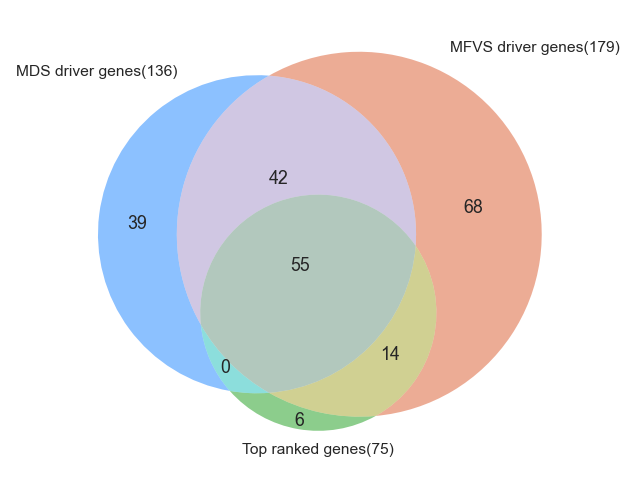

In [19]:
result.plot_driver_genes_Venn()

Plot heat map of the activity matrix of RGMs

<Figure size 320x320 with 0 Axes>

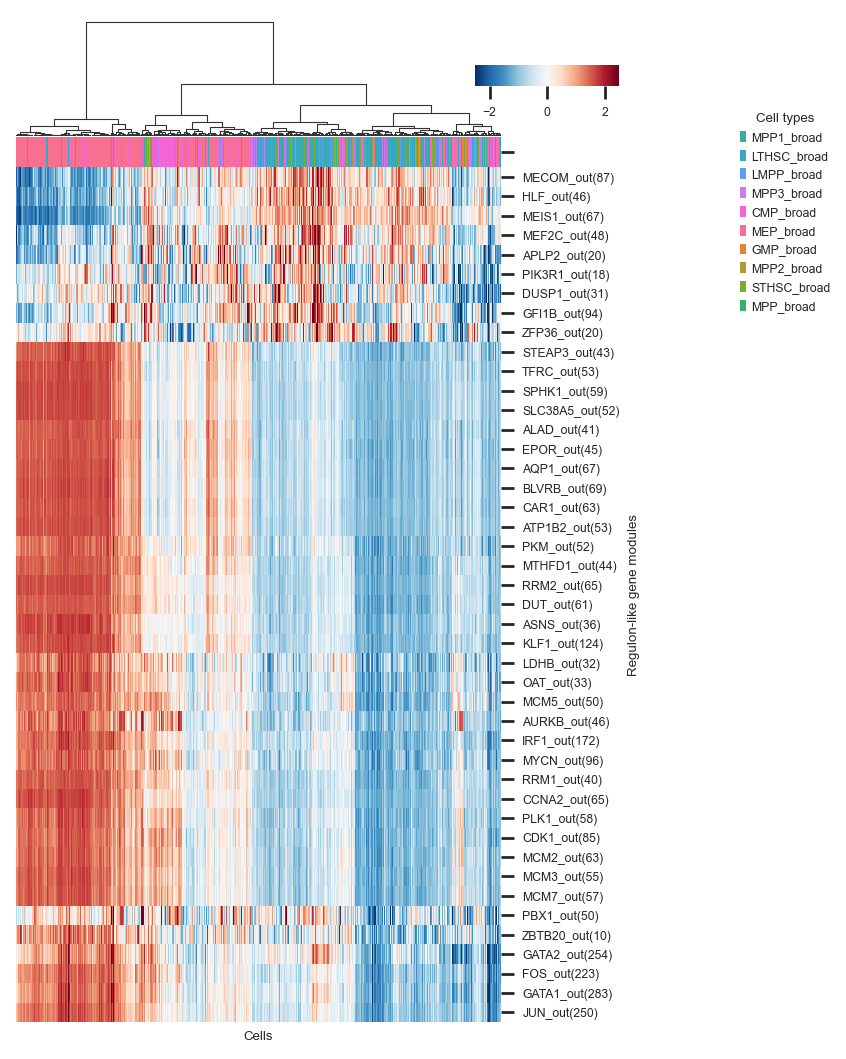

In [20]:
adata_lineage = adata[adata.obs_names[adata.obs[result.name].notna()],:]

result.plot_RGM_activity_heatmap(cell_label=adata_lineage.obs['cell_type_finely'],
                                 type='out',col_cluster=True,bbox_to_anchor=(1.48, 0.25))
